# King Street Pilot Bluetooth Baseline Quality Check

In [2]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time
import numpy as np

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [33]:
sql = '''SELECT base.daytype,
	('2017-11-12 ' || base.time::varchar)::timestamp as time,
	base.avg_tt as base_tt,
	base.analysis_id,

	percentile_cont(0.0) WITHIN GROUP (ORDER BY bt.travel_time) as pct_0,
	percentile_cont(0.2) WITHIN GROUP (ORDER BY bt.travel_time) as pct_20,
	percentile_cont(0.4) WITHIN GROUP (ORDER BY bt.travel_time) as pct_40,
	percentile_cont(0.5) WITHIN GROUP (ORDER BY bt.travel_time) as pct_50,
    percentile_cont(0.6) WITHIN GROUP (ORDER BY bt.travel_time) as pct_60,
	percentile_cont(0.8) WITHIN GROUP (ORDER BY bt.travel_time) as pct_80,
	percentile_cont(1.0) WITHIN GROUP (ORDER BY bt.travel_time) as pct_100
	
FROM king_pilot_baselines base
	INNER JOIN dt_30min_agg bt ON (bt.analysis_id = base.analysis_id AND bt.datetime_bin::time = base.time AND 
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'weekday' ELSE 'weekend' END = base.daytype)

WHERE bt.datetime_bin::date <= '2017-11-12'
	AND bt.datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'

GROUP BY base.analysis_id, base.time, base.daytype, base.avg_tt
'''

travel_times = pandasql.read_sql(sql, con)

In [4]:
colors = ['#003A72', '#d83904']

In [46]:
travel_times[:5]

,daytype,time,base_tt,analysis_id,pct_0,pct_20,pct_40,pct_50,pct_60,pct_80,pct_100
0,weekday,2017-11-12 00:00:00,223.595635,1453138,148.00000,198.937778,221.800000,225.194444,227.700000,241.000000,346.0
1,weekend,2017-11-12 00:00:00,278.669048,1453138,227.00000,238.440000,251.895238,254.424242,263.450000,279.813333,409.0
2,weekday,2017-11-12 00:30:00,216.456944,1453138,141.00000,179.200000,201.800000,211.343750,217.200000,248.800000,368.0
3,weekend,2017-11-12 00:30:00,298.671458,1453138,232.90625,265.983333,277.026667,282.666667,292.591667,332.066667,411.0
4,weekday,2017-11-12 01:00:00,225.577137,1453138,143.00000,188.300000,210.590000,219.000000,228.133333,241.400000,381.0


In [44]:
def plot_base(observations, r_name):
    #Divide data into Week and Weekend buckets for the given route name. 
    segments = {'week' : observations[(observations['analysis_id'] == r_name) & 
                         (observations['daytype'] == 'weekday')].sort_values(['time']),
                'weekend' : observations[(observations['analysis_id'] == r_name) & 
                         (observations['daytype'] == 'weekend')].sort_values(['time'])}
    segments
        
    fig, daytype = plt.subplots(2, 1, figsize = (16,14))
    
    for i, (color, WD) in enumerate(zip(colors, ['weekend', 'week'])):        
        
        daytype[i].set_title('Baseline for ' + str(r_name) + ' during the ' + str(WD))
        daytype[i].plot_date(x = segments[WD].time,
                          y = segments[WD].base_tt,
                          xdate = True,
                          fmt = '-o',
                          c = color,
                          label = WD)
        
        daytype[i].fill_between(segments[WD].time.values, 
                            y1=segments[WD]['pct_0'],
                            y2=segments[WD]['pct_100'],
                            alpha=0.15, facecolor=color)
        daytype[i].fill_between(segments[WD].time.values, 
                            y1=segments[WD]['pct_20'],
                            y2=segments[WD]['pct_80'],
                            alpha=0.25, facecolor=color)
        daytype[i].fill_between(x = segments[WD].time.values, 
                            y1=segments[WD]['pct_40'],
                            y2=segments[WD]['pct_60'],
                            alpha=0.35, facecolor=color)
        
        daytype[i].xaxis.set_major_locator(mdates.HourLocator(interval = 3))
        daytype[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        
        daytype[i].xaxis.set_label_text('Time')
        daytype[i].yaxis.set_label_text('Travel Time')
        
        daytype[i].yaxis.grid(True)
        daytype[i].xaxis.grid(True)
    
    daytype[0].legend()
    daytype[1].legend(loc = 'upper left')
    
    plt.show()

In [27]:
sinnister_segments = [1453138, 1453284, 1453627, 1453653, 1453752, 1453719, 1454050, 1454241, 1454605, 1454879, 1454907, 1454997, 1455076, 1455088, 1455231, 1455243, 1455351, 1455538, 1455555, 1455628, 1455676]

For the graphs below both the weekend and weekday baselines are plotted, therefore some graphs will not contain outliers. 

To be added to the 'sinnister segments' list, the baseline had to exhibit a pattern that wasn't reflected in the 40-60 percentile band due to a spike in the 0-100 percentile band. This was generally a sudden spike in 0-100 that brough the baseline beyond the bounds of the 20-80 percentile band.

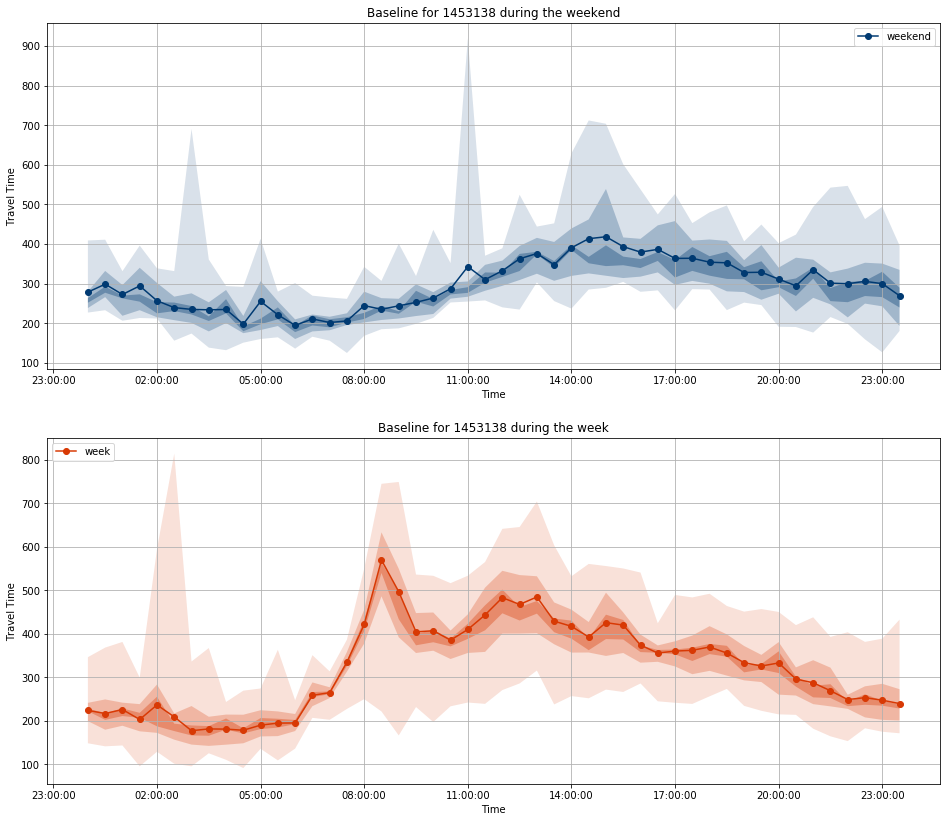

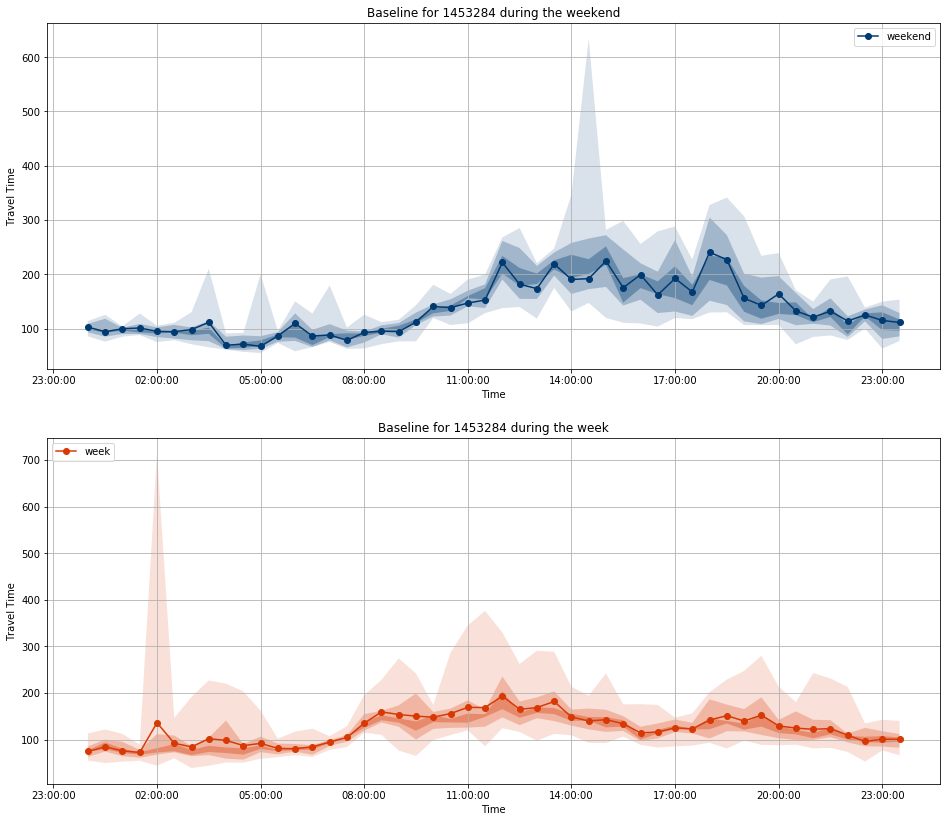

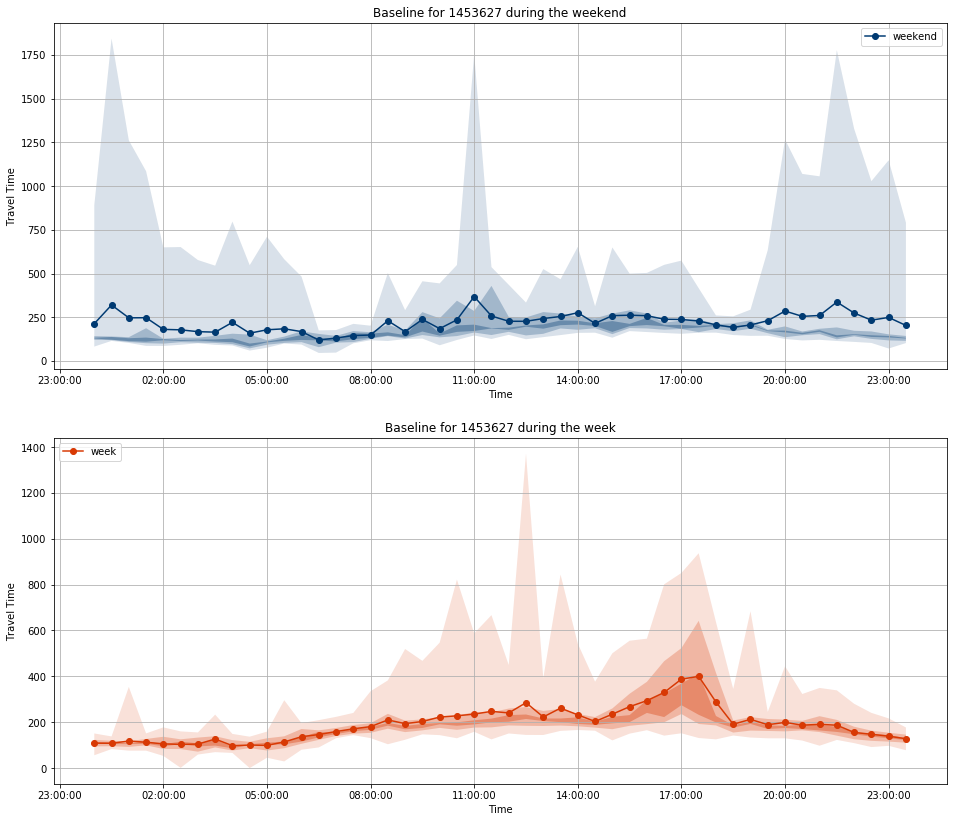

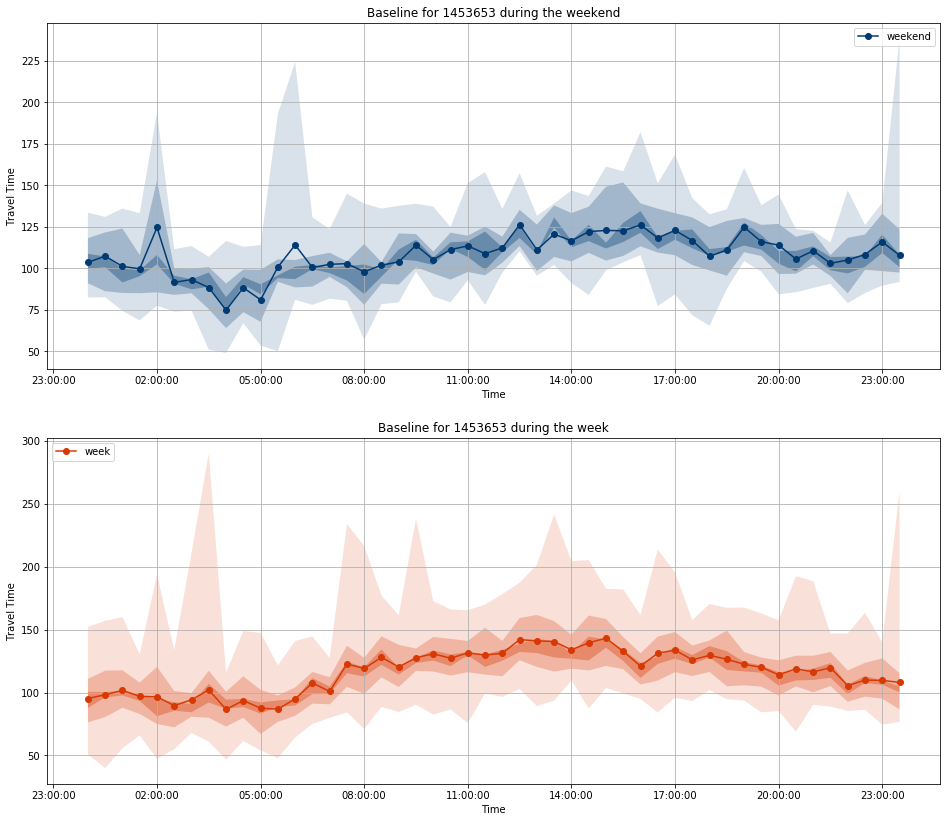

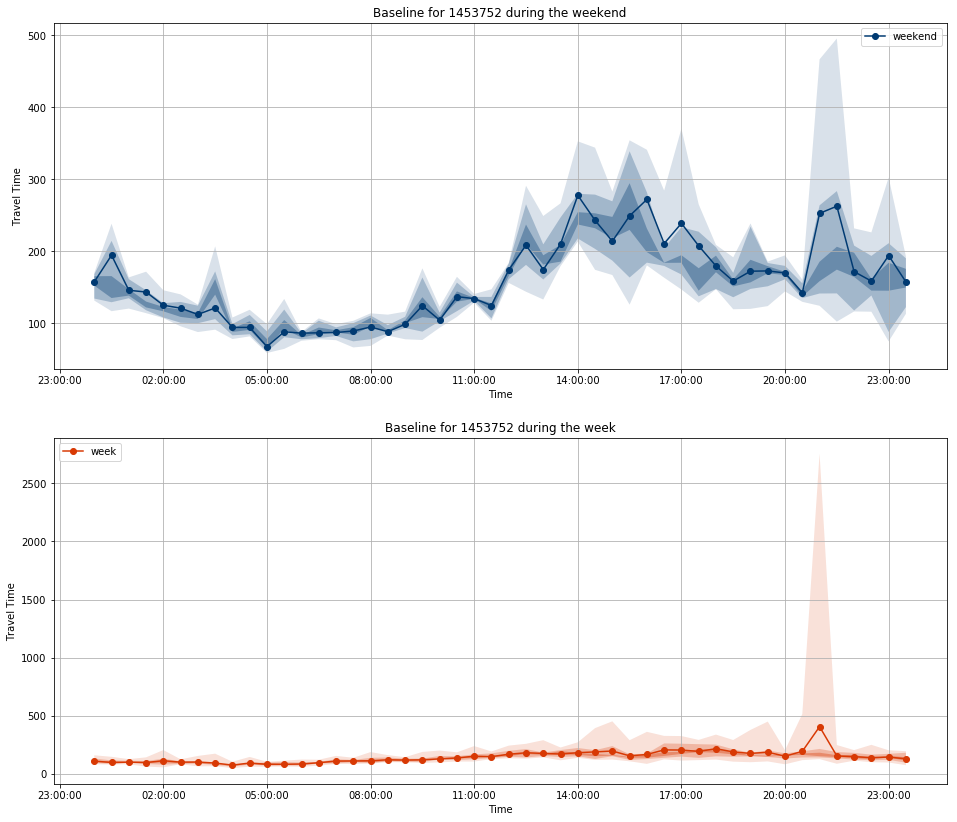

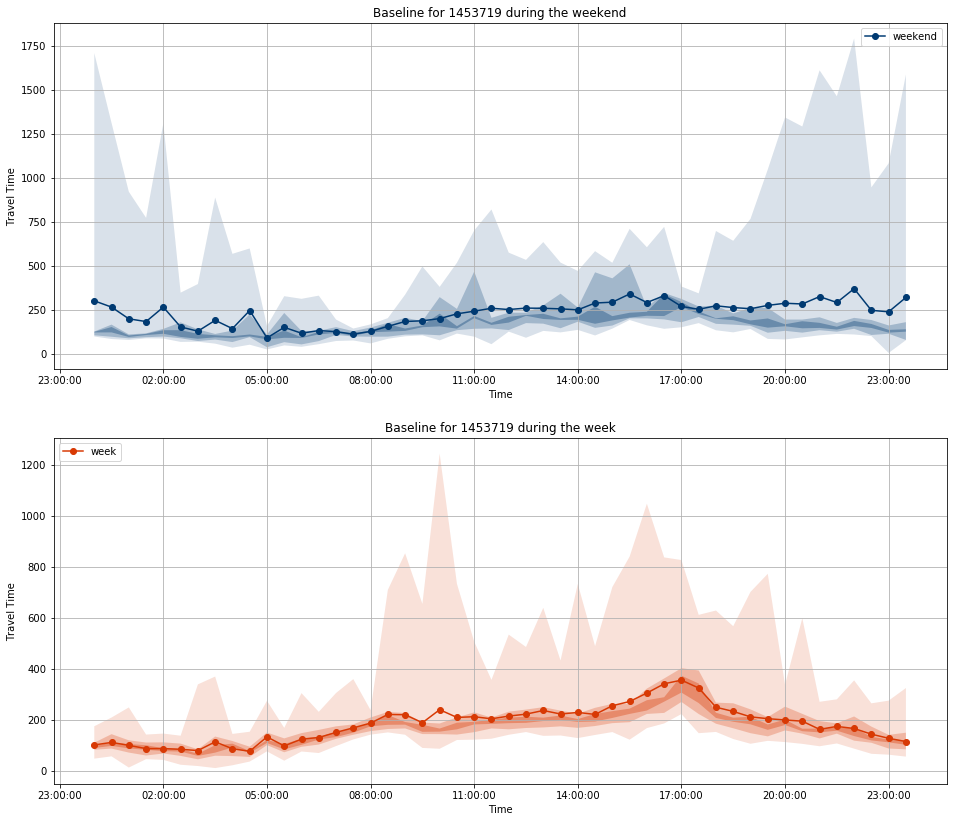

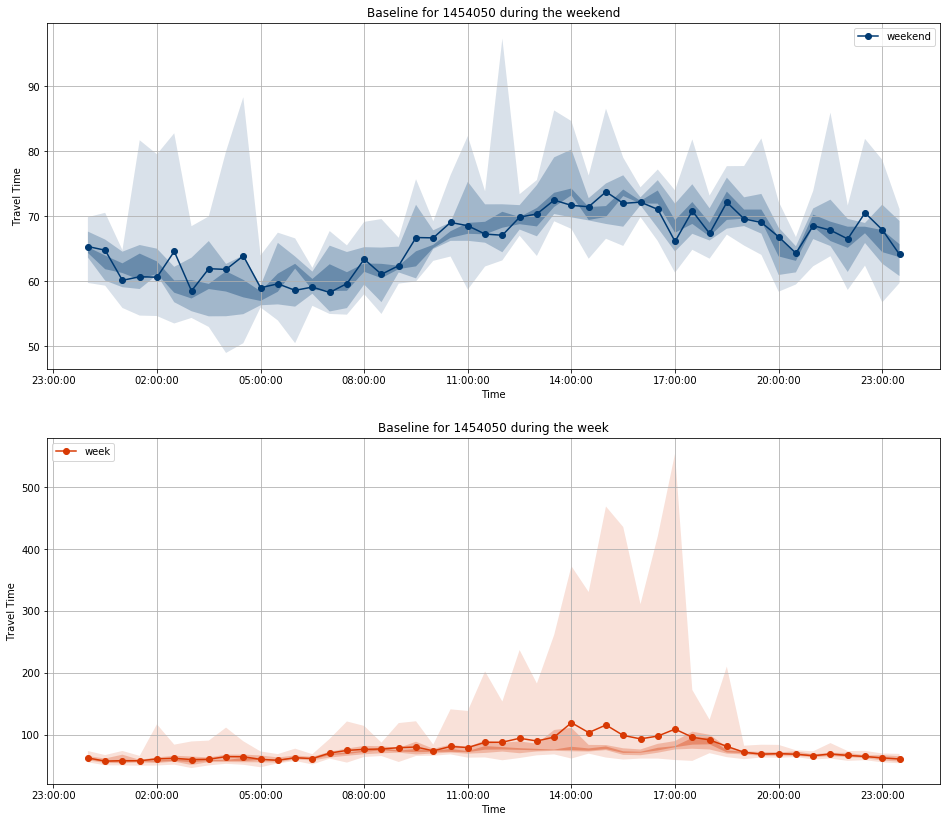

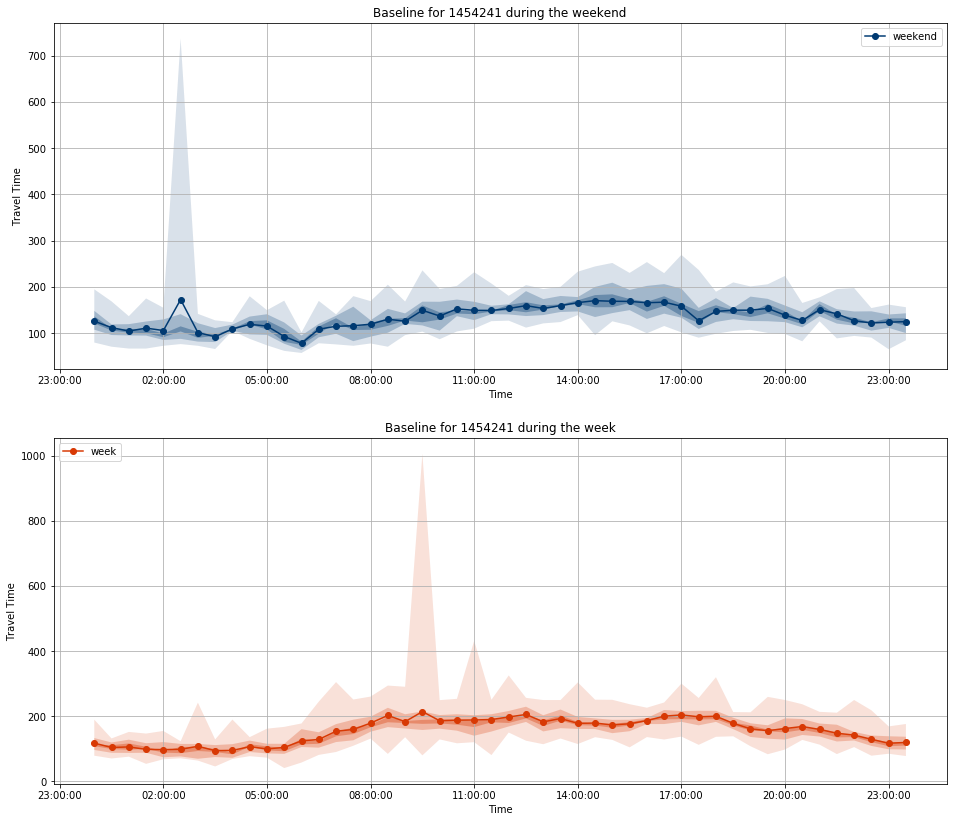

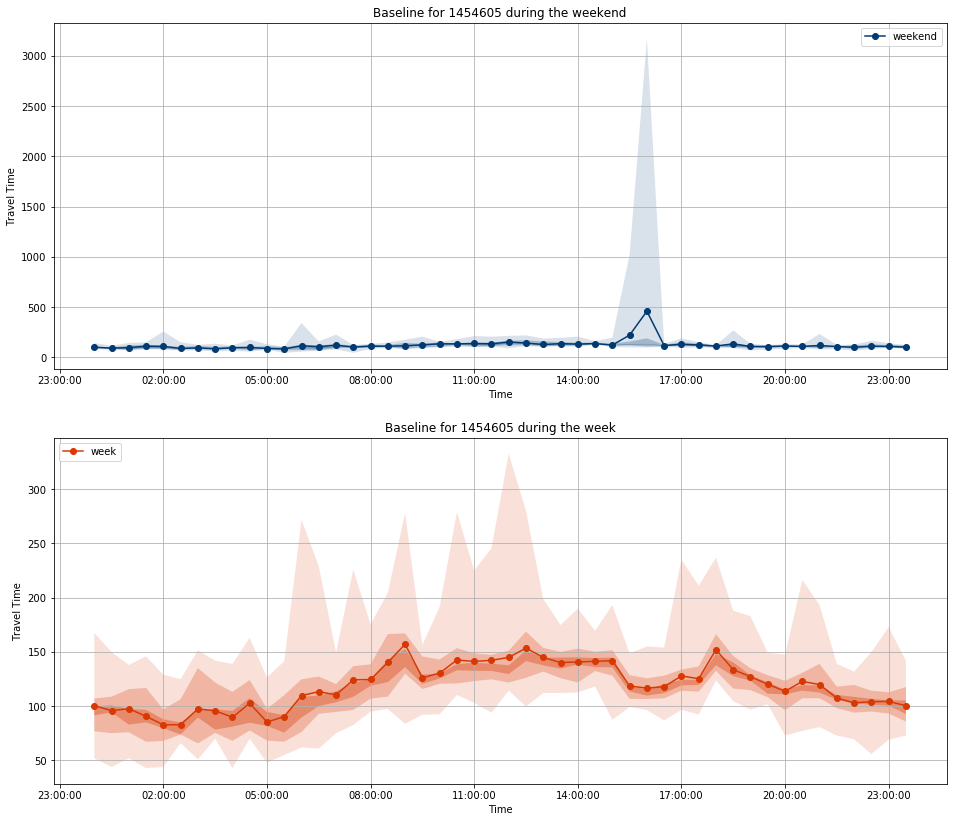

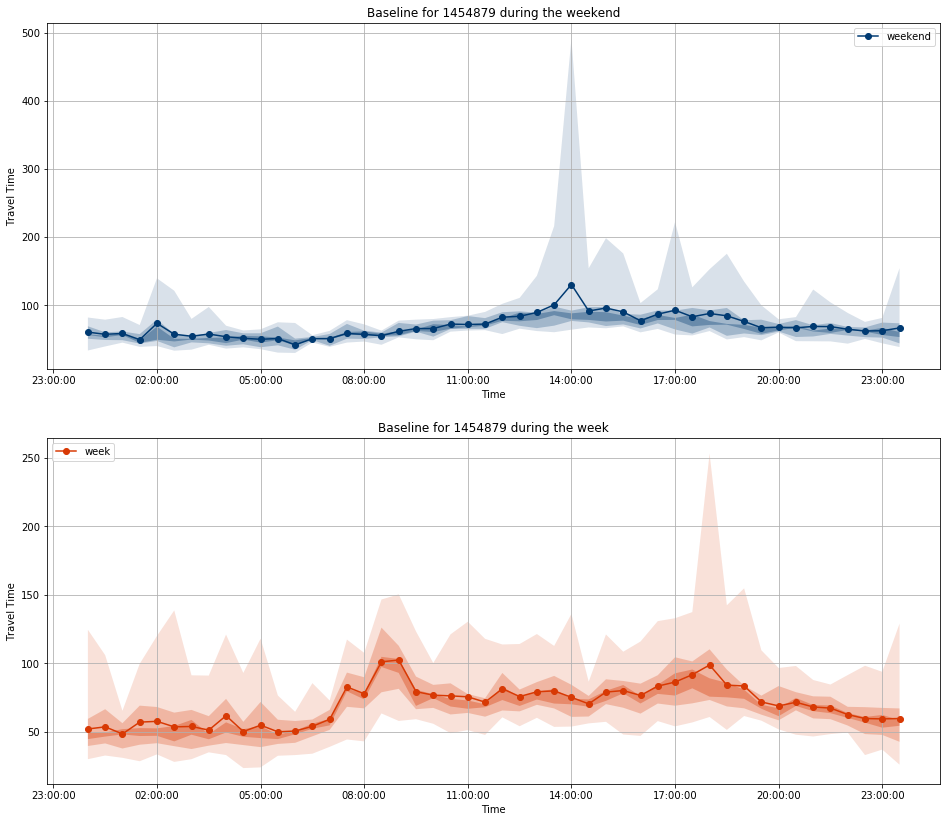

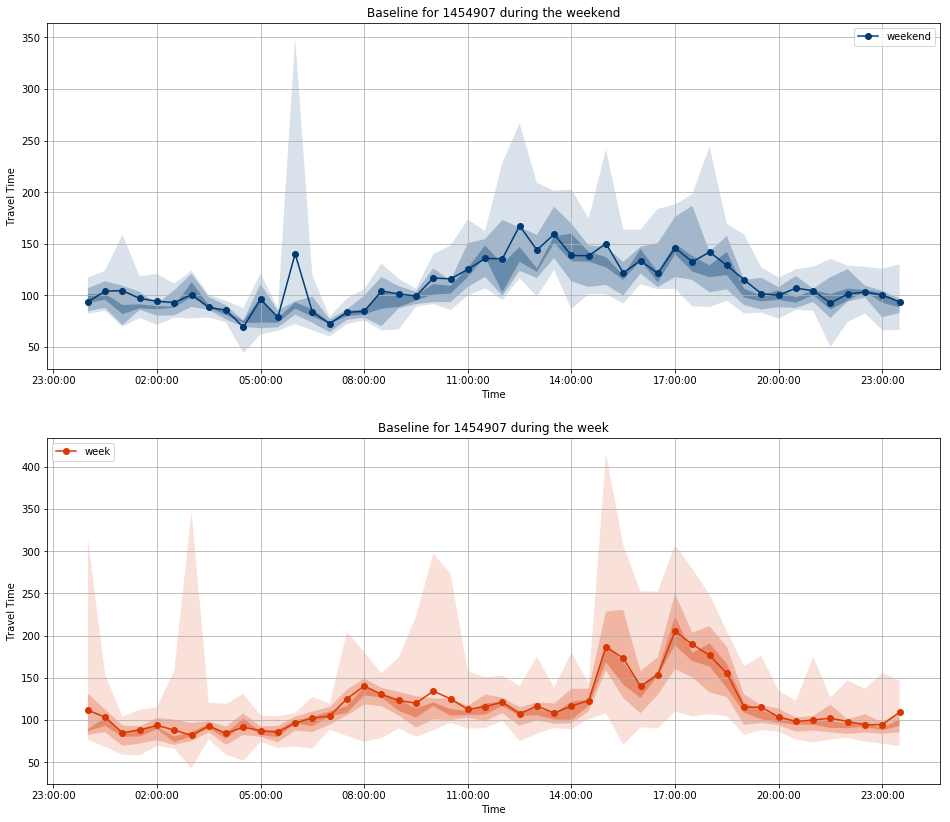

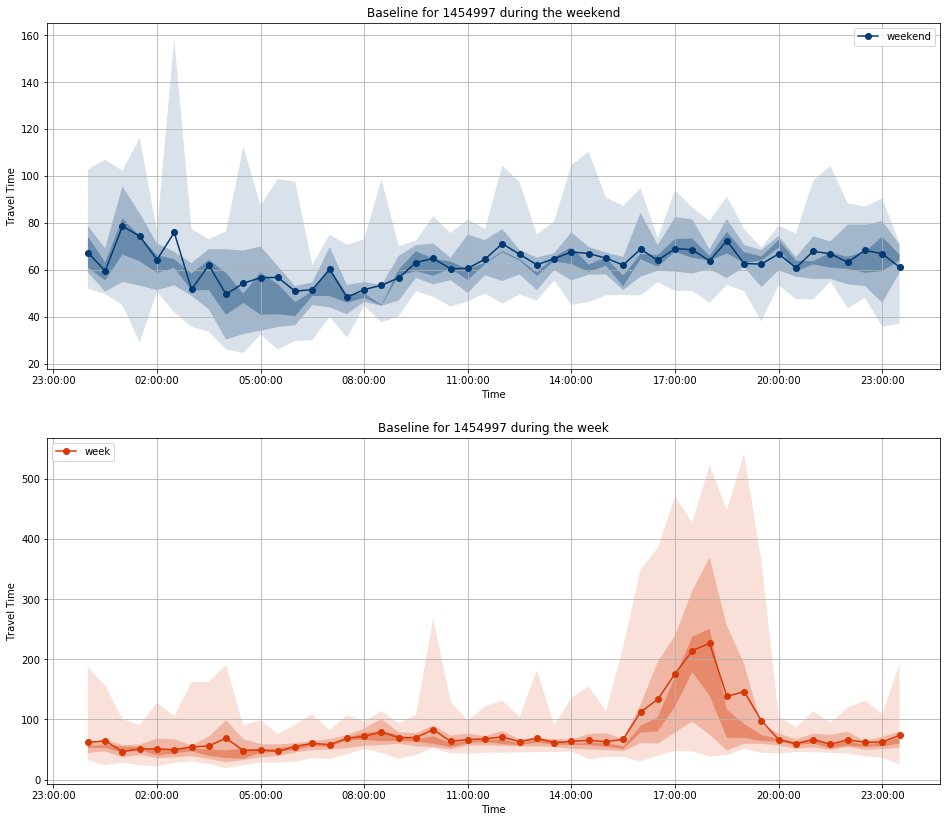

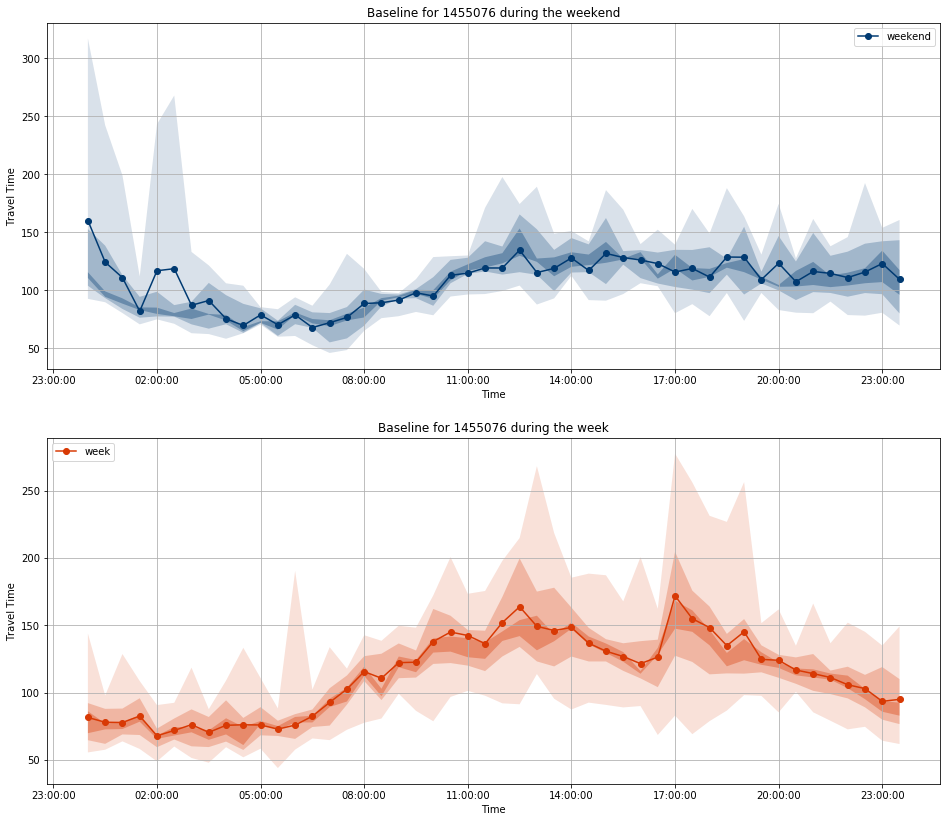

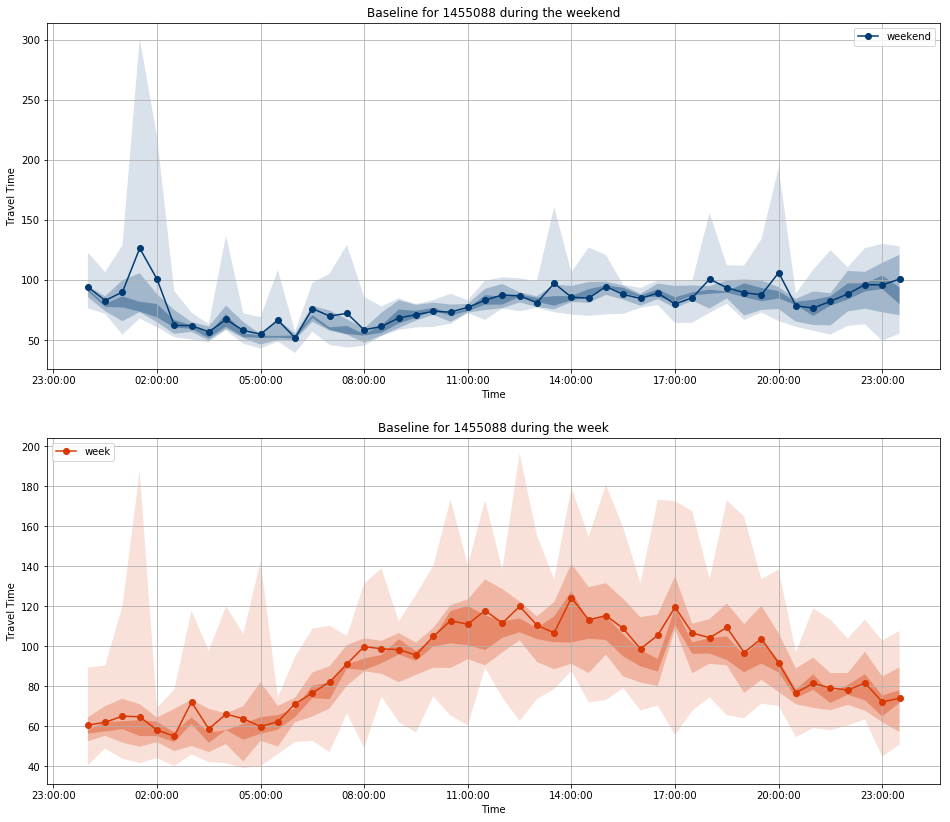

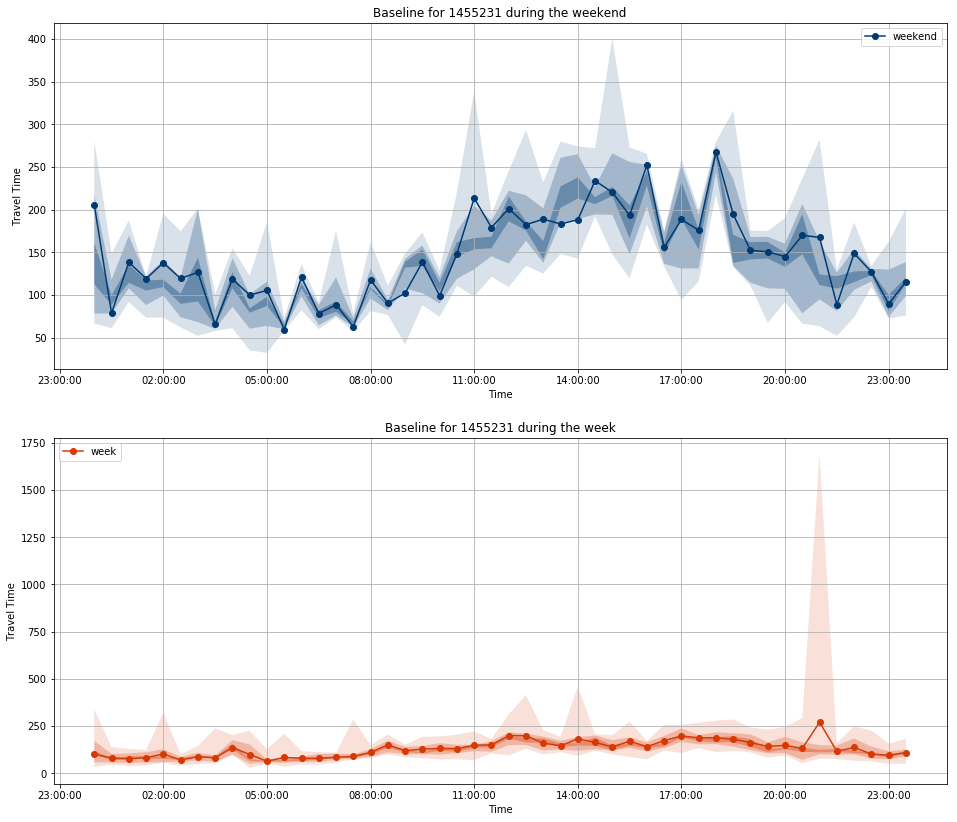

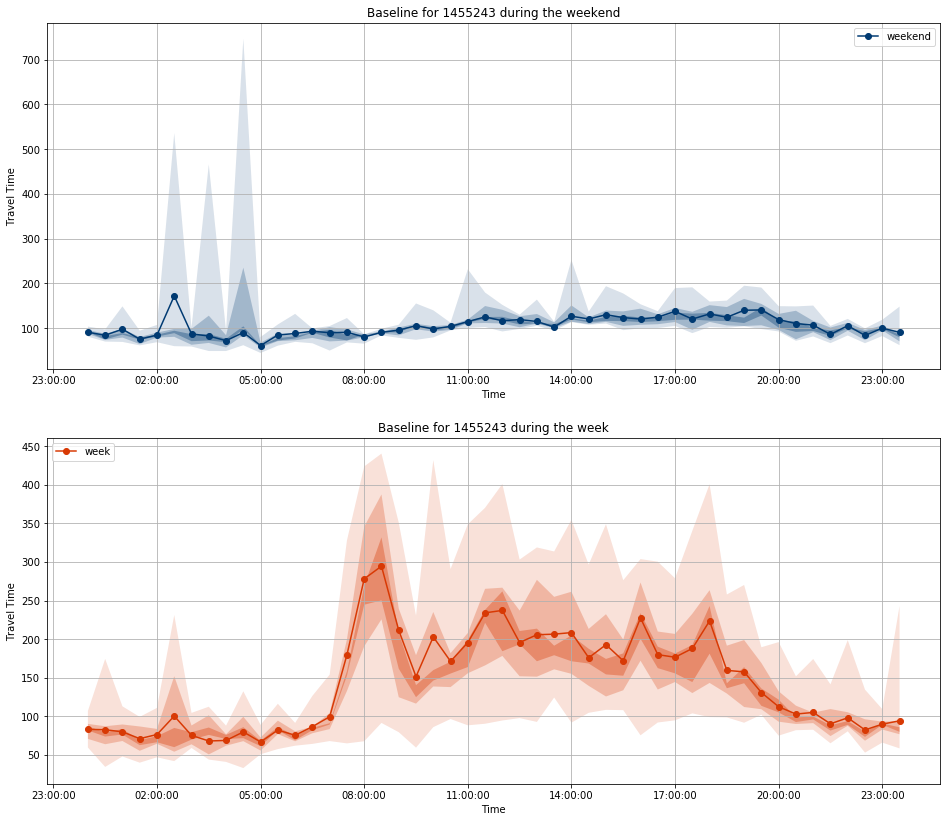

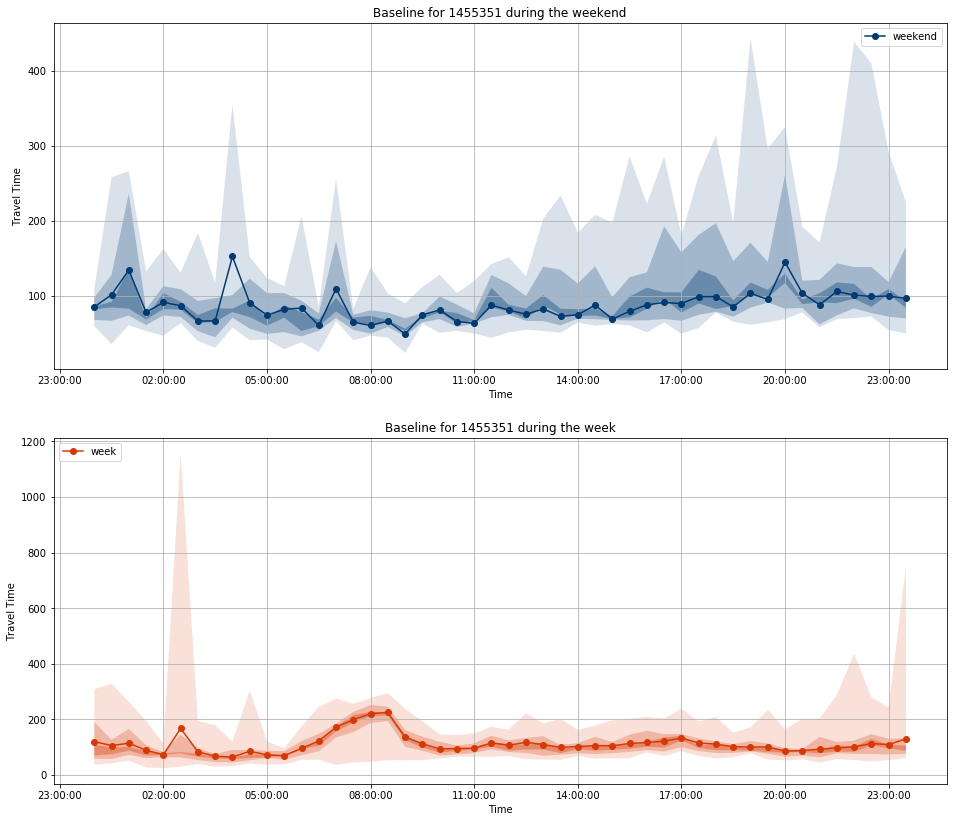

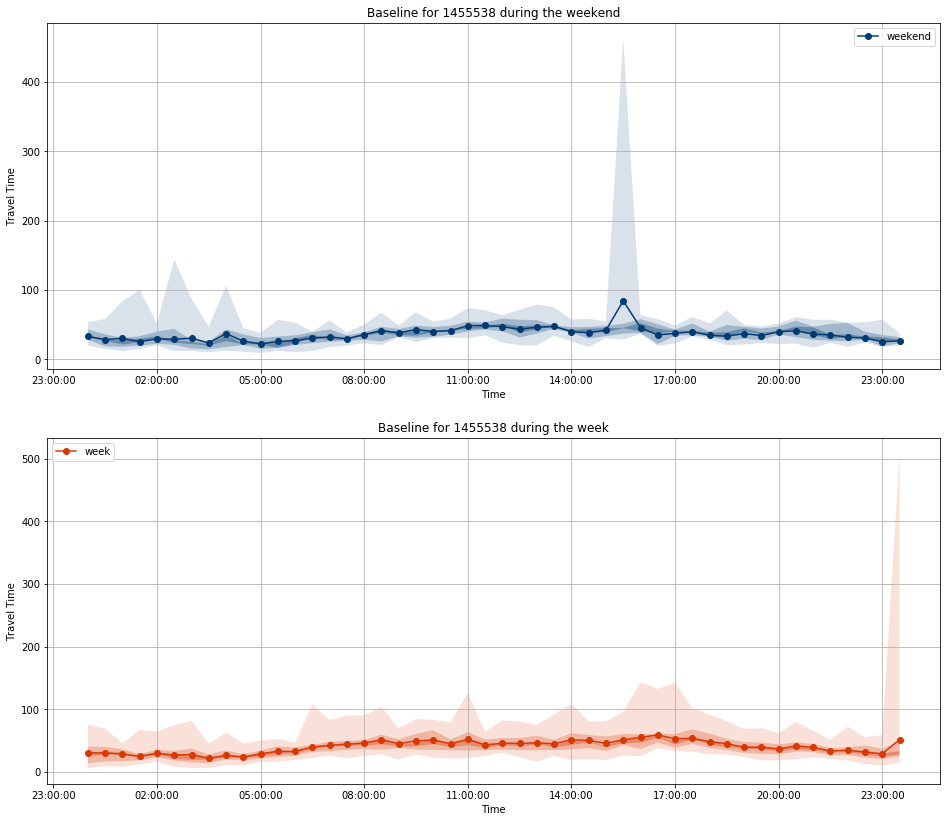

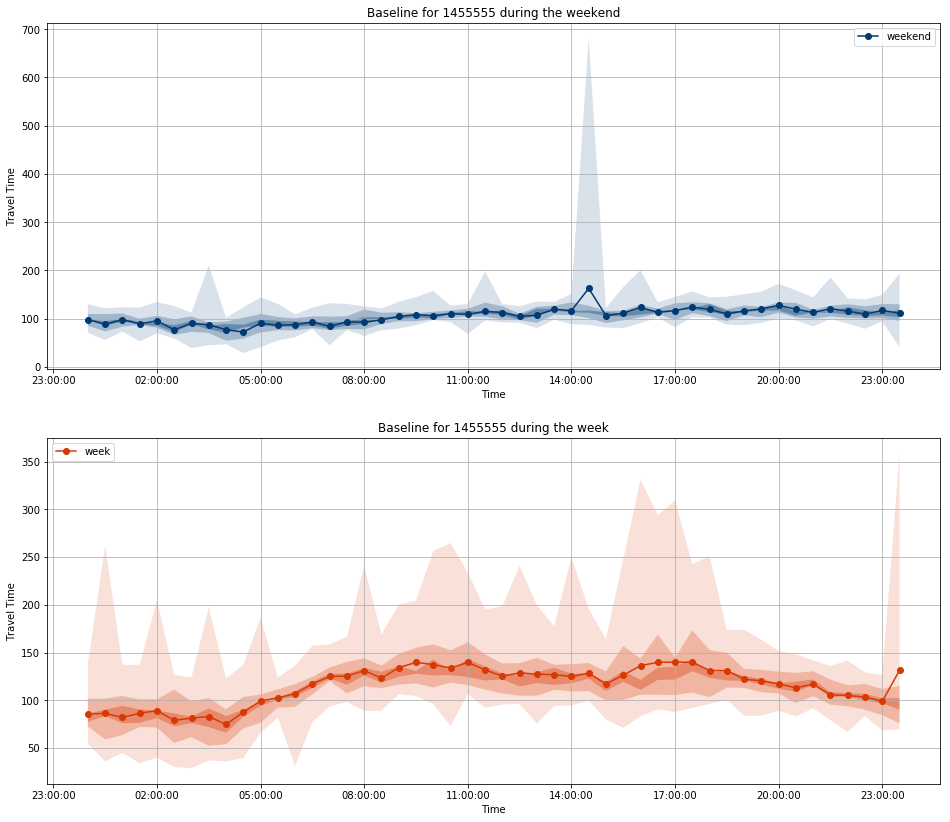

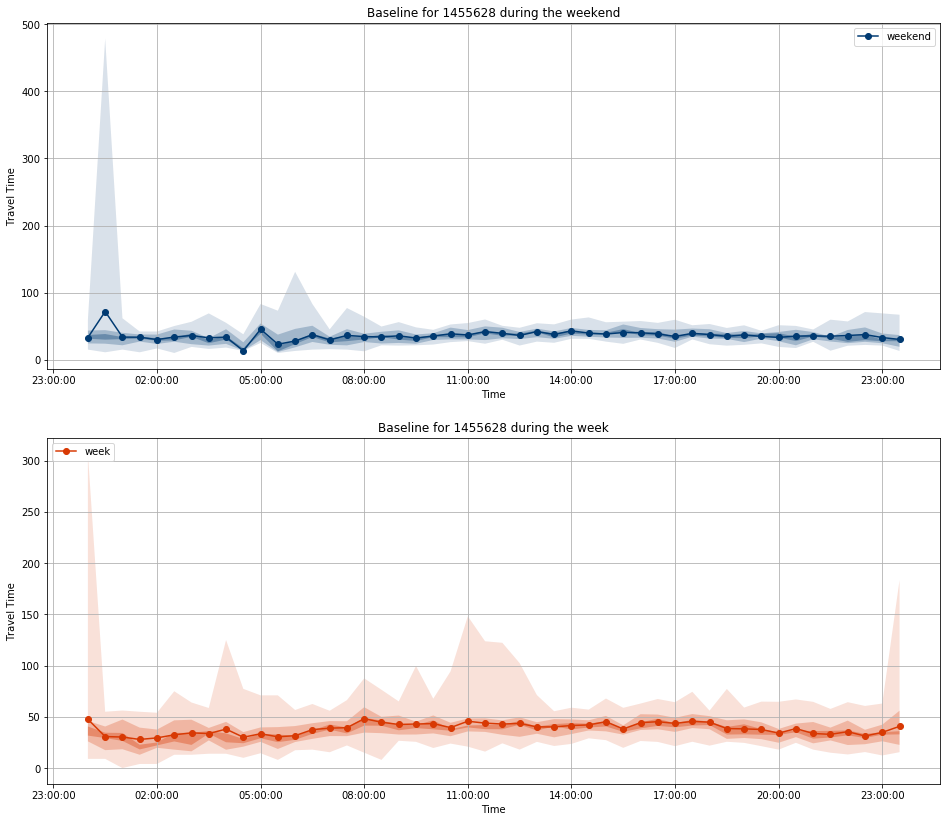

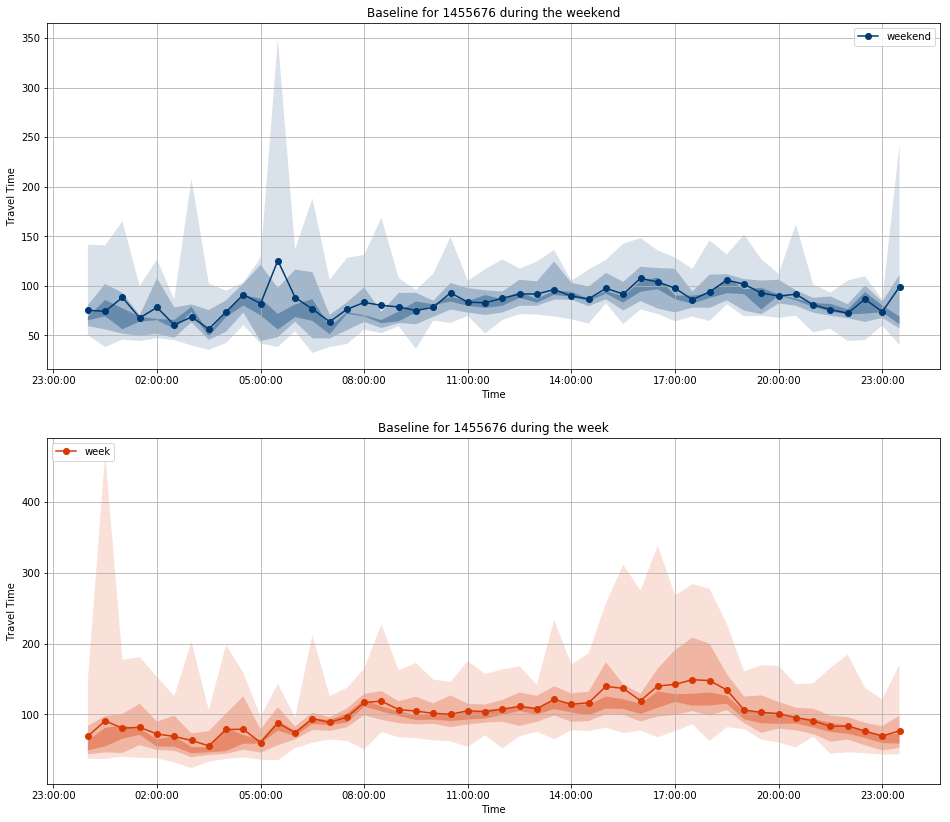

In [45]:
for sin_seg in sinnister_segments:
    plot_base(travel_times, sin_seg)